# ModEx Framework: Integrated Geophysical-Hydrologic Analysis

This notebook implements the ModEx framework for optimal survey design by integrating:
1. Geophysical uncertainty analysis  
2. Resistivity-saturation relationships (Archie's law)
3. Investigation interest index (III)
4. Spatial clustering for survey location optimization


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
from scipy import odr
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Parflow imports
import os
from parflow.tools.io import read_pfb

print("All packages imported successfully!")


All packages imported successfully!


In [ ]:
## Step 1: Load Resistivity Data

#Load resistivity predictions with uncertainties. We'll keep the full grid for now and filter using the ParFlow mask after adding saturation data.



In [ ]:
# Load resistivity predictions with uncertainties from full spatial grid
df_resistivity = pd.read_csv("terrain_with_predicted_resistivity.csv")

# Keep full dataframe (will filter using ParFlow mask after adding saturation data)
df = df_resistivity.copy()

print(f"Loaded {len(df)} total points from full spatial grid")
print(f"Grid dimensions: {df['x'].nunique()} x {df['y'].nunique()} points")


Loaded 66010 total points from full spatial grid
Grid dimensions: 66010 x 66002 points


## Step 2: Load Saturation Data from ParFlow

Load saturation data from ParFlow ensemble runs and calculate statistics in linear space.


In [ ]:
# Load saturation data from ParFlow runs
sat_data2 = read_pfb('./test2/test2.out.satur.07560.pfb')
sat_data4 = read_pfb('./test4/test4.out.satur.07560.pfb')
sat_data5 = read_pfb('./test5/test5.out.satur.07560.pfb')
porosity = read_pfb('./test5/test5.out.porosity.pfb')
mask = read_pfb('./test2/test2.out.mask.pfb')

# Stack ensemble members
stacked_sat = np.stack([sat_data2, sat_data4, sat_data5], axis=0)

# Calculate statistics in LINEAR space (consistent)
sat_mean = np.mean(stacked_sat, axis=0)  # Mean in linear space
sat_std = np.std(stacked_sat, axis=0)    # Std in linear space

# Remove invalid values
sat_mean = np.where(sat_mean > 0, sat_mean, 0.01)
sat_std = np.where(sat_std >= 0, sat_std, 0.001)

print(f"Saturation range: {sat_mean.min():.3f} to {sat_mean.max():.3f}")
print(f"Saturation std range: {sat_std.min():.4f} to {sat_std.max():.4f}")


Saturation range: 0.010 to 1.000
Saturation std range: 0.0000 to 0.1328


## Step 3: Add Saturation to DataFrame

Extract saturation data for each depth layer and add to the main dataframe.


In [ ]:
# Define depth layers
layers = ['0.50m', '0.75m', '1.00m', '1.25m', '1.50m', '2.00m', 
          '2.50m', '3.00m', '3.50m', '4.00m', '4.50m', '5.00m']

# Extract saturation, std, and porosity for each layer
for idx, layer in enumerate(layers):
    layer_idx = 13 - idx
    
    sat_layer = sat_mean[layer_idx, ::-1, :].flatten()
    sat_std_layer = sat_std[layer_idx, ::-1, :].flatten()
    por_layer = porosity[layer_idx, ::-1, :].flatten()
    
    df[f'sat_{layer}'] = sat_layer
    df[f'sat_std_{layer}'] = sat_std_layer
    df[f'porosity_{layer}'] = por_layer

print(f"Added saturation data for {len(layers)} depth layers")


Added saturation data for 12 depth layers


## Step 3b: Create and Visualize Mask

Extract the mask from the ParFlow data to identify valid catchment areas. This helps visualize which areas are active in the simulation.


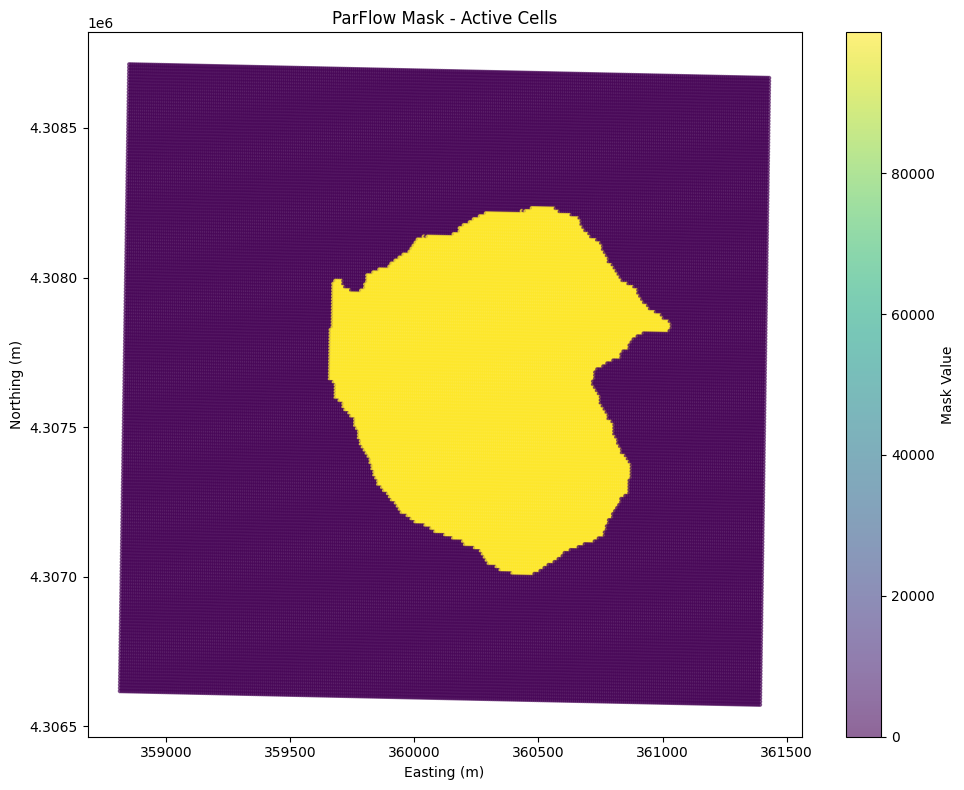

Active cells: 13604 / 66010
Percentage active: 20.6%


In [ ]:
# Extract mask from layer 13 (top layer), flip vertically, and flatten
mask1 = mask[13, ::-1, :].flatten()

# Visualize the mask
plt.figure(figsize=(10, 8))
plt.scatter(df['x'], df['y'], c=mask1, cmap='viridis', s=5, alpha=0.6)
plt.colorbar(label='Mask Value')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('ParFlow Mask - Active Cells')
plt.tight_layout()
plt.show()

# Create boolean mask column (True where mask > 0, indicating active cells)
df['mask'] = mask1 > 0

print(f"Active cells: {df['mask'].sum()} / {len(df)}")
print(f"Percentage active: {100 * df['mask'].sum() / len(df):.1f}%")


## Step 3c: Filter to Catchment Area

Now that saturation data and mask are added, filter to only the active catchment cells using the ParFlow mask.


In [ ]:
# Filter using mask (active cells in ParFlow simulation)
# Following the approach from load_wc.ipynb
mask_filter = df['mask'] == True
df_filter = df[mask_filter].copy()

print(f"Filtered to {len(df_filter)} points with active mask")
print(f"Percentage of total: {100 * len(df_filter) / len(df_resistivity):.1f}%")

# Use df_filter as the main dataframe going forward
df = df_filter.copy()
print(f"\nFinal dataset size: {len(df)} points")


Filtered to 13604 points with active mask
Percentage of total: 20.6%

Final dataset size: 13604 points


## Step 3d: Verify Filtered Data

Visualize the filtered saturation and resistivity data to ensure proper integration.


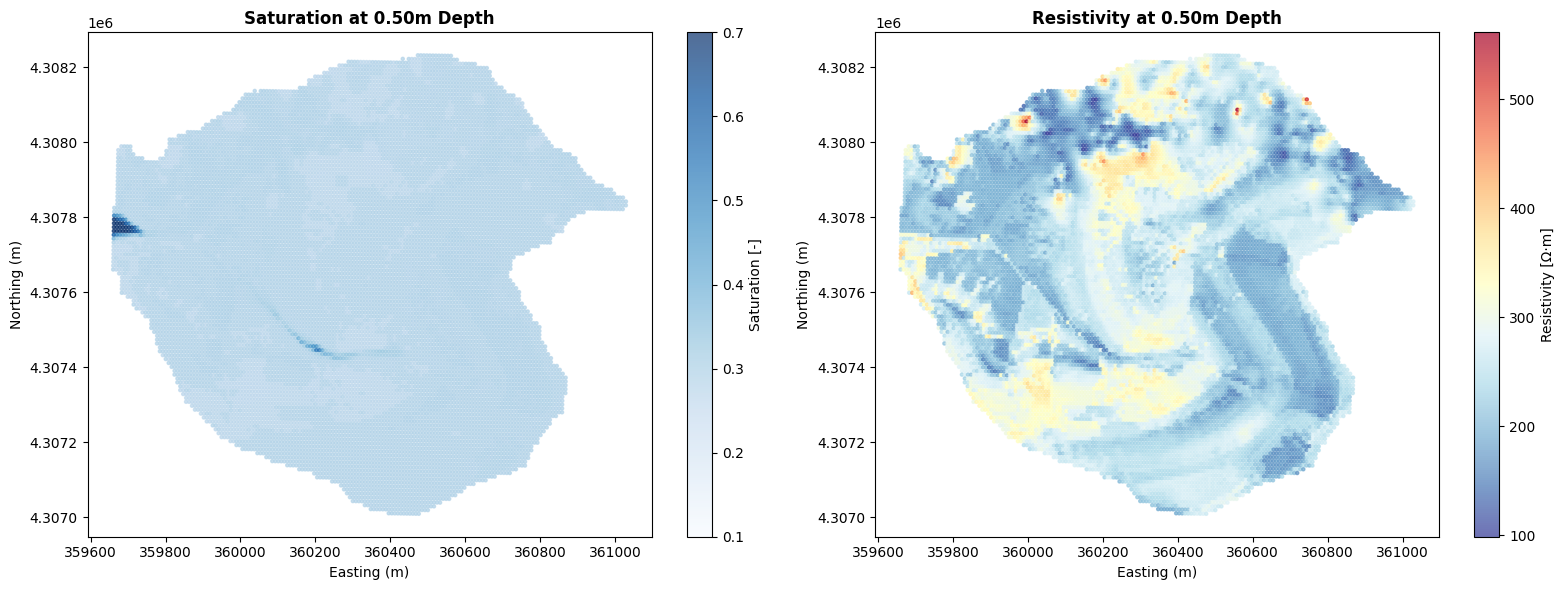

Saturation range at 0.50m: 0.264 to 1.000
Resistivity range at 0.50m: 98.8 to 561.4 Ω·m


In [ ]:
# Create side-by-side comparison plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Saturation at 0.50m depth
ax = axes[0]
sc1 = ax.scatter(df['x'], df['y'], c=df['sat_0.50m'], 
                 cmap='Blues', s=5, alpha=0.7, vmin=0.1, vmax=0.7)
ax.set_title('Saturation at 0.50m Depth', fontsize=12, fontweight='bold')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.colorbar(sc1, ax=ax, label='Saturation [-]')

# Plot 2: Resistivity at 0.50m depth
ax = axes[1]
sc2 = ax.scatter(df['x'], df['y'], c=df['layer_0.50m'], 
                 cmap='RdYlBu_r', s=5, alpha=0.7)
ax.set_title('Resistivity at 0.50m Depth', fontsize=12, fontweight='bold')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.colorbar(sc2, ax=ax, label='Resistivity [Ω·m]')

plt.tight_layout()
plt.show()

print(f"Saturation range at 0.50m: {df['sat_0.50m'].min():.3f} to {df['sat_0.50m'].max():.3f}")
print(f"Resistivity range at 0.50m: {df['layer_0.50m'].min():.1f} to {df['layer_0.50m'].max():.1f} Ω·m")


## Step 3e: Handle Missing Uncertainty Values

Fill NaN values in resistivity uncertainty columns with a default value of 10 Ω·m. This is necessary for robust ODR fitting in Archie's law calculations.


In [ ]:
# Find all uncertainty columns (following load_wc.ipynb approach)
cols_uncertainty = [col for col in df.columns if '_uncertainty_std' in col]

print(f"Found {len(cols_uncertainty)} uncertainty columns")
print(f"Columns: {cols_uncertainty[:3]}... (showing first 3)")

# Check for NaN values before filling
nan_counts_before = df[cols_uncertainty].isna().sum()
total_nans_before = nan_counts_before.sum()
print(f"\nNaN values before filling: {total_nans_before}")

# Fill NaN values with 10 (default uncertainty value)
df[cols_uncertainty] = df[cols_uncertainty].fillna(10)

# Verify NaN values are filled
nan_counts_after = df[cols_uncertainty].isna().sum()
total_nans_after = nan_counts_after.sum()
print(f"NaN values after filling: {total_nans_after}")
print(f"\n✓ All uncertainty NaN values replaced with 10 Ω·m")


Found 12 uncertainty columns
Columns: ['layer_0.50m_uncertainty_std', 'layer_0.75m_uncertainty_std', 'layer_1.00m_uncertainty_std']... (showing first 3)

NaN values before filling: 36384
NaN values after filling: 0

✓ All uncertainty NaN values replaced with 10 Ω·m


## Step 4: Archie's Law Parameter Estimation

Calculate Archie's law parameters using Orthogonal Distance Regression (ODR) with proper uncertainty propagation:
- **Model**: log(ρ) = a·log(S) + b
- **Method**: ODR accounts for uncertainties in both x and y variables


In [ ]:
from sklearn.linear_model import LinearRegression
def calculate_archie_parameters(row, layers):
    """
    Calculate Archie's law parameters: log(ρ) = a·log(S) + b
    
    Uses ODR with proper uncertainty propagation to log space.
    Formula for uncertainty propagation: σ_log(x) ≈ σ_x / x
    """
    # Extract values
    resist_values = np.array([row[f'layer_{layer}'] for layer in layers])
    resist_std = np.array([row[f'layer_{layer}_uncertainty_std'] for layer in layers])
    sat_values = np.array([row[f'sat_{layer}'] for layer in layers])
    sat_std = np.array([row[f'sat_std_{layer}'] for layer in layers])
    
    # Filter valid data points
    valid_mask = (resist_values > 0) & (sat_values > 0) & (sat_values <= 1)
    
    if np.sum(valid_mask) < 3:
        return np.nan, np.nan, np.nan, np.nan, np.nan
    
    resist_values = resist_values[valid_mask]
    resist_std = resist_std[valid_mask]
    sat_values = sat_values[valid_mask]
    sat_std = sat_std[valid_mask]
    
    # Set minimum uncertainties to avoid division by zero
    sat_std = np.maximum(sat_std, 0.001)
    resist_std = np.maximum(resist_std, 1.0)
    
    # Transform to log space
    log_resist = np.log(resist_values)
    log_sat = np.log(sat_values)
    
    # Propagate uncertainties to log space: σ_log(x) ≈ σ_x / x
    log_resist_std = resist_std / resist_values
    log_sat_std = sat_std / sat_values

    X = np.log(np.array(sat_values).reshape(-1, 1))
    y = log_resist
        
    reg = LinearRegression().fit(X, y)
    slope_a = np.minimum(reg.coef_[0],-0.01)
    intercept_b = reg.intercept_   

    # Define linear model for ODR
    def lin_model(B, x):
        return B[0] * x + B[1]
    
    # Set up ODR
    model = odr.Model(lin_model)
    data = odr.RealData(log_sat, log_resist, sx=log_sat_std, sy=log_resist_std)
    odr_inst = odr.ODR(data, model, beta0=[-1 , 5])  # Negative slope expected
    
    try:
        out = odr_inst.run()
        slope_a, intercept_b = out.beta
        slope_err, intercept_err = out.sd_beta
        corr_coef, _ = pearsonr(log_sat, log_resist)
        
        return slope_a, intercept_b, slope_err, intercept_err, corr_coef
    except:
        return np.nan, np.nan, np.nan, np.nan, np.nan

# Apply to all points
print("Calculating Archie's law parameters...")
results = df.apply(lambda row: calculate_archie_parameters(row, layers), axis=1)

df['slope_a'] = results.apply(lambda x: x[0])
df['intercept_b'] = results.apply(lambda x: x[1])
df['slope_err'] = results.apply(lambda x: x[2])
df['intercept_err'] = results.apply(lambda x: x[3])
df['correlation'] = results.apply(lambda x: x[4])

print(f"\nResults:")
print(f"  Slope (a): {df['slope_a'].mean():.3f} ± {df['slope_a'].std():.3f}")
print(f"  Intercept (b): {df['intercept_b'].mean():.3f} ± {df['intercept_b'].std():.3f}")
print(f"  Valid points: {df['slope_a'].notna().sum()} / {len(df)}")


Calculating Archie's law parameters...

Results:
  Slope (a): -0.113 ± 0.158
  Intercept (b): 5.832 ± 0.387
  Valid points: 13604 / 13604


## Step 5: Calculate Coefficient of Variation (CV)

Calculate CV for both resistivity and saturation across depth layers to quantify spatial heterogeneity.

**Important**: Following `load_wc.ipynb`:
- **Resistivity CV**: Calculated in **LOG space** → `std(log(ρ)) / mean(log(ρ))`
- **Saturation CV**: Calculated in **LINEAR space** → `std(S) / mean(S)`

This matches the proven approach from `load_wc.ipynb` for geological interest calculation.


In [ ]:
def calculate_resist_cv(row, layers):
    """Calculate resistivity CV in LOG space (following load_wc.ipynb)"""
    resist_values = [row[f'layer_{layer}'] for layer in layers]
    resist_values = np.array(resist_values)
    resist_values = resist_values[resist_values > 0]  # Remove invalid values
    
    if len(resist_values) < 3:
        return np.nan
    
    # CV in LOG space for resistivity
    return np.std(np.log(resist_values)) / np.mean(np.log(resist_values))

def calculate_sat_cv(row, layers):
    """Calculate saturation CV in LINEAR space (following load_wc.ipynb)"""
    sat_values = [row[f'sat_{layer}'] for layer in layers]
    sat_values = np.array(sat_values)
    sat_values = sat_values[sat_values > 0]  # Remove invalid values
    
    if len(sat_values) < 3:
        return np.nan
    
    # CV in LINEAR space for saturation
    return np.std(sat_values) / np.mean(sat_values)

# Calculate resistivity CV (LOG space) - following load_wc.ipynb
df['resist_cv'] = df.apply(lambda row: calculate_resist_cv(row, layers), axis=1)

# Calculate saturation CV (LINEAR space) - following load_wc.ipynb
df['sat_cv'] = df.apply(lambda row: calculate_sat_cv(row, layers), axis=1)

print(f"Resistivity CV (log space): {df['resist_cv'].mean():.3f}")
print(f"Saturation CV (linear space): {df['sat_cv'].mean():.3f}")


Resistivity CV (log space): 0.033
Saturation CV (linear space): 0.257


## Step 6: Investigation Interest Index (III)

Calculate the Investigation Interest Index combining:
1. Geophysical uncertainty (CV of resistivity)
2. Hydrologic variability (CV of saturation)
3. Model fit quality (correlation coefficient)

**Formula**: III = Normalize[(CV_ρ + CV_S) + (1-|r|)] × 100


In [ ]:
# Calculate raw III: (CV_ρ + CV_S) + (1-|r|)
df['III_raw'] = (df['resist_cv'] + df['sat_cv']) + (1 - np.abs(df['correlation']))

# Normalize to 0-100 scale
valid_mask = df['III_raw'].notna()
min_val = df.loc[valid_mask, 'III_raw'].min()
max_val = df.loc[valid_mask, 'III_raw'].max()
df['III'] = 100 * (df['III_raw'] - min_val) / (max_val - min_val)

print(f"III Statistics:")
print(f"  Range: {df['III'].min():.2f} to {df['III'].max():.2f}")
print(f"  Mean: {df['III'].mean():.2f}")
print(f"  Median: {df['III'].median():.2f}")


III Statistics:
  Range: 0.00 to 100.00
  Mean: 60.71
  Median: 63.34


## Step 7: K-means Clustering for Catchment Zonation

Cluster locations based on terrain features and resistivity layers to identify hydrogeologically similar zones. Following the approach from `load_wc.ipynb`.


In [ ]:
# Set environment variable before sklearn operations (following load_wc.ipynb)
import os
os.environ["SKLEARN_ENABLE_THREADPOOL_LIMITS"] = "0"  # set BEFORE importing sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select clustering features: terrain attributes + all resistivity layers
clustering_columns = [
    'elevation', 'slope', 'aspect', 'plan_curvature',
    'layer_0.50m', 'layer_0.75m', 'layer_1.00m', 'layer_1.25m', 'layer_1.50m',
    'layer_2.00m', 'layer_2.50m', 'layer_3.00m', 'layer_3.50m', 'layer_4.00m',
    'layer_4.50m', 'layer_5.00m'
]
feature_cols = clustering_columns

print(f"Using {len(feature_cols)} features for clustering:")
print(f"  - Terrain: elevation, slope, aspect, plan_curvature")
print(f"  - Resistivity: 12 depth layers (0.50m to 5.00m)")

# Extract features for clustering
X = df[feature_cols].values
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply K-means clustering (following load_wc.ipynb exactly)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_normalized)

# Add cluster labels to dataframe
df['cluster'] = clusters

# Print cluster distribution
print(f"\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())


Using 16 features for clustering:
  - Terrain: elevation, slope, aspect, plan_curvature
  - Resistivity: 12 depth layers (0.50m to 5.00m)

Cluster distribution:
0    5757
1    3296
2    4551
Name: count, dtype: int64


## Step 8: Visualization - Four-Panel ModEx Framework

Create comprehensive visualization showing:
- **(a)** Geophysical Uncertainty (resistivity CV)
- **(b)** Resistivity-Saturation Relationship (Archie's intercept)
- **(c)** Catchment Zonation (K-means clusters)
- **(d)** Investigation Interest Index (III)


                   x             y  avg_uncertainty
14371  360473.463382  4.308232e+06              NaN
14372  360481.490802  4.308232e+06              NaN
14373  360489.518223  4.308232e+06              NaN
14374  360497.545643  4.308231e+06              NaN
14375  360505.573063  4.308231e+06              NaN
High: 836, Medium: 3187, Low: 9581


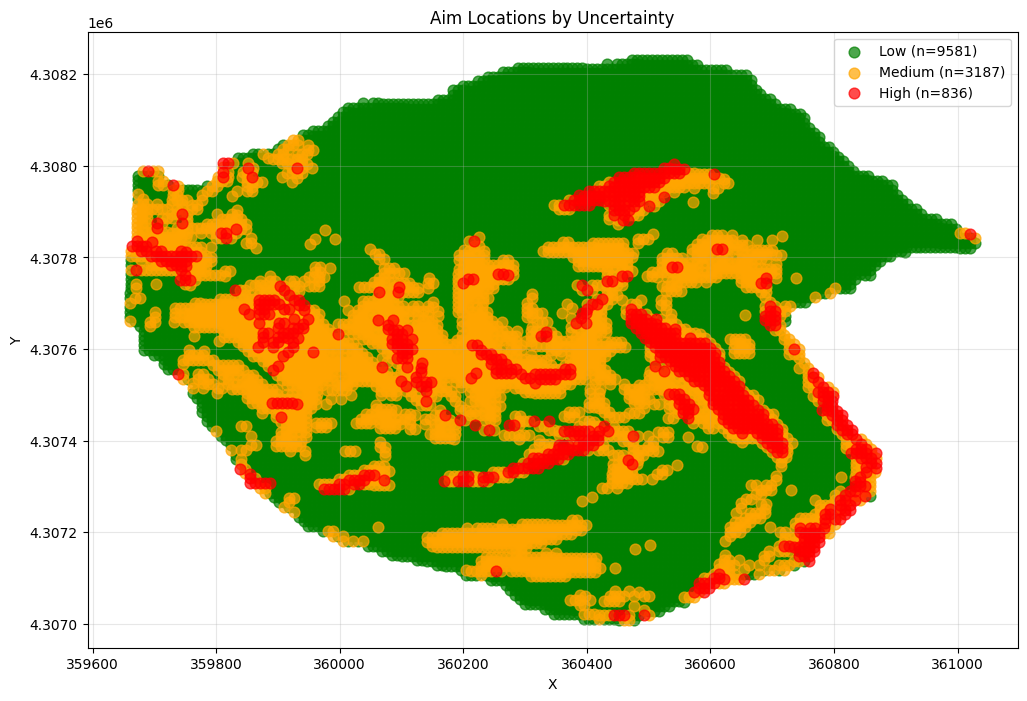

Top 5 high priority:
(360744, 4307169) - 109.6%
(360606, 4307099) - 73.7%
(360818, 4307280) - 68.4%
(360370, 4307381) - 64.3%
(360420, 4307924) - 64.1%


In [ ]:
# Load comprehensive resistivity predictions
ML_df = pd.read_csv("terrain_with_comprehensive_resistivity_predictions.csv")

# Filter using the ParFlow mask (active cells)
filtered_data = ML_df[mask1 > 0].copy()

# Define the full list of depths as strings
depths = ['0.50', '0.75', '1.00', '1.25', '1.50', '2.00', 
          '2.50', '3.00', '3.50', '4.00', '4.50', '5.00']

# Get the CV% columns
cv_percent_cols = [col for col in filtered_data.columns if col.endswith('_cv_percent')]

# Calculate the row-wise average across all depths for CV%
filtered_data['avg_uncertainty'] = filtered_data[cv_percent_cols].mean(axis=1)

# Display the first few rows of the new column
print(filtered_data[['x', 'y', 'avg_uncertainty']].head())

# Apply thresholds
high_threshold = 40
medium_threshold = 30

filtered_data['cluster'] = 'Low'
filtered_data.loc[filtered_data['avg_uncertainty'] >= medium_threshold, 'cluster'] = 'Medium'
filtered_data.loc[filtered_data['avg_uncertainty'] >= high_threshold, 'cluster'] = 'High'

filtered_data['priority'] = filtered_data['cluster'].map({'High': 1, 'Medium': 2, 'Low': 3})
filtered_data = filtered_data.sort_values(['priority', 'avg_uncertainty'], ascending=[True, False])

print(f"High: {sum(filtered_data['cluster']=='High')}, Medium: {sum(filtered_data['cluster']=='Medium')}, Low: {sum(filtered_data['cluster']=='Low')}")

# Create map
plt.figure(figsize=(12, 8))
colors = {'High': 'red', 'Medium': 'orange', 'Low': 'green'}

for cluster in ['Low', 'Medium', 'High']:
    data = filtered_data[filtered_data['cluster'] == cluster]
    plt.scatter(data['x'], data['y'], c=colors[cluster], 
               label=f'{cluster} (n={len(data)})', s=60, alpha=0.7)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Aim Locations by Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('aim_uncertainty_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results
filtered_data[['x', 'y', 'avg_uncertainty', 'cluster', 'priority']].to_csv('aim_uncertainty_clusters.csv', index=False)

print("Top 5 high priority:")
for _, row in filtered_data[filtered_data['cluster']=='High'].head().iterrows():
    print(f"({row['x']:.0f}, {row['y']:.0f}) - {row['avg_uncertainty']:.1f}%")

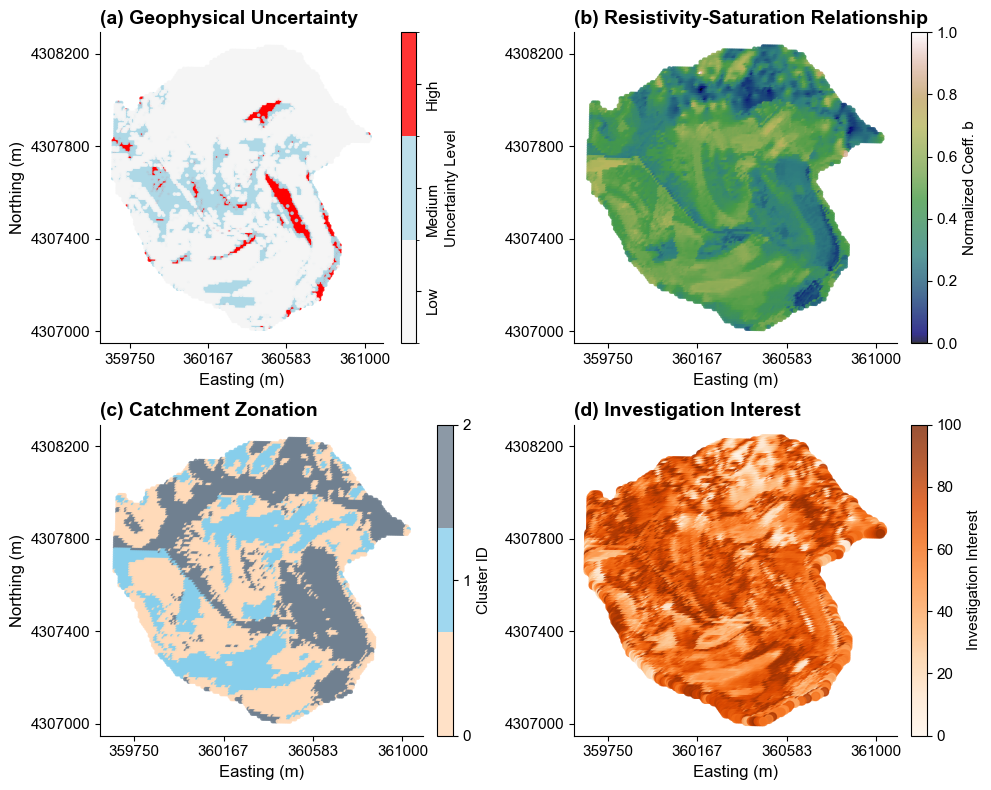


Figure saved as 'ModEx_Framework_Analysis.png'


In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Set plot parameters
import matplotlib.pylab as pylab
params = {'legend.fontsize': 12, 'axes.labelsize': 12, 'axes.titlesize': 14,
         'xtick.labelsize': 11, 'ytick.labelsize': 11}
pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"

# Define colors for uncertainty levels
colors_dict = {'Low': 'whitesmoke', 'Medium': 'lightblue', 'High': 'red'}
cluster_labels = ['Low', 'Medium', 'High']
color_list = [colors_dict[label] for label in cluster_labels]
cmap_uncertainty = ListedColormap(color_list)
bounds = [0, 1, 2, 3]
norm_uncertainty = BoundaryNorm(bounds, cmap_uncertainty.N)

# 1) define your own three colors however you like
my_colors = ['peachpuff', 
             'skyblue',  
             'slategray',

             ]  

# 2) build a ListedColormap from them
cmap3 = ListedColormap(my_colors)



# Number of clusters for visualization
n_clusters = 3

# Define axis ticks
x_ticks = [359750, 360167, 360583, 361000]
y_ticks = [4307000, 4307400, 4307800, 4308200]

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# ========== Panel (a): Geophysical Uncertainty ==========
ax = axes[0]
sc = ax.scatter(filtered_data['x'], filtered_data['y'],
                c=filtered_data['cluster'].map({'Low': 0, 'Medium': 1, 'High': 2}),
                cmap=cmap_uncertainty, norm=norm_uncertainty, alpha=0.8, s=3)
ax.set_title('(a) Geophysical Uncertainty', loc='left', fontweight='bold')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
cbar = fig.colorbar(sc, ax=ax, ticks=[0.5, 1.5, 2.5])
cbar.ax.set_yticklabels(cluster_labels, rotation=90)
cbar.set_label('Uncertainty Level', fontsize=11)

# ========== Panel (b): Resistivity-Saturation Relationship ==========


b = df['intercept_b']
b_norm = (b - b.min()) / (b.max() - b.min())

ax = axes[1]
sc = ax.scatter(df['x'], df['y'], c=b_norm, cmap='gist_earth', s=5, alpha=0.8, vmin=0, vmax=1)
ax.set_title('(b) Resistivity-Saturation Relationship', loc='left', fontweight='bold')
ax.set_xlabel('Easting (m)')
#ax.set_ylabel('Northing (m)')
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Normalized Coeff. b', fontsize=11)

# ========== Panel (c): Catchment Zonation ==========
ax = axes[2]
sc = ax.scatter(df['x'], df['y'], c=df['cluster'], cmap=cmap3, s=5, alpha=0.8)
ax.set_title('(c) Catchment Zonation', loc='left', fontweight='bold')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, ticks=range(n_clusters))
cbar.set_label('Cluster ID', fontsize=11)

# ========== Panel (d): Investigation Interest ==========
ax = axes[3]
sc = ax.scatter(df['x'], df['y'], c=df['III'], cmap='Oranges', alpha=0.8, vmin=0, vmax=100)
ax.set_title('(d) Investigation Interest', loc='left', fontweight='bold')
ax.set_xlabel('Easting (m)')
# ax.set_ylabel('Northing (m)')
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Investigation Interest', fontsize=11)

plt.tight_layout()
plt.savefig('ModEx_Framework_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'ModEx_Framework_Analysis.png'")


Data Prepared:
  High uncertainty points: 688
  Medium uncertainty points: 2719


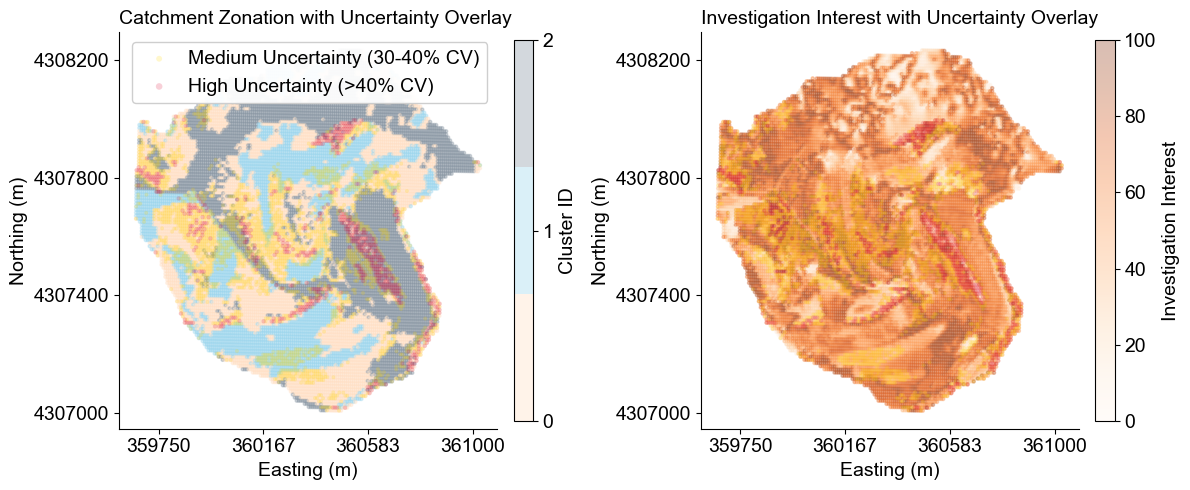


✓ Figure created successfully!
  Panels: 2 (c and d)
  Panel (c): Catchment Zonation + Uncertainty Overlay
    - Medium points (gold): 2719
    - High points (red): 688
  Panel (d): Investigation Interest + Uncertainty Overlay
    - Medium points (gold): 2719
    - High points (red): 688

  Output files:
    - Figure_Zonation_Investigation_Overlay.png (300 dpi)
    - Figure_Zonation_Investigation_Overlay.pdf (vector)


In [ ]:
# ========== Step 1: Prepare the data ==========

# Merge filtered_data (uncertainty) with df (catchment zones + III)
plot_data = df.merge(
    filtered_data[['x', 'y', 'cluster', 'avg_uncertainty']],
    on=['x', 'y'],
    how='left',
    suffixes=('_zone', '_uncertainty')
)

# Filter for High and Medium uncertainty points
high_uncertainty_points = plot_data[plot_data['cluster_uncertainty'] == 'High']
medium_uncertainty_points = plot_data[plot_data['cluster_uncertainty'] == 'Medium']

print("Data Prepared:")
print(f"  High uncertainty points: {len(high_uncertainty_points)}")
print(f"  Medium uncertainty points: {len(medium_uncertainty_points)}")

# ========== Step 2: Create the 2-panel figure ==========

from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

# Set plot parameters
params = {'legend.fontsize': 14, 'axes.labelsize': 14, 'axes.titlesize': 14,
         'xtick.labelsize': 14, 'ytick.labelsize': 14}
pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"

# Define catchment zonation colors
my_colors = ['peachpuff', 'skyblue', 'slategray']
cmap3 = ListedColormap(my_colors)

# Define axis ticks
x_ticks = [359750, 360167, 360583, 361000]
y_ticks = [4307000, 4307400, 4307800, 4308200]

# Create figure with 1x2 layout (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ========== Panel (c): Catchment Zonation with Uncertainty Overlay ==========
ax = axes[0]

# Layer 1: Background - Catchment zonation (faded)
sc = ax.scatter(df['x'], df['y'], 
                c=df['cluster'], 
                cmap=cmap3, 
                s=5, 
                alpha=0.3,
                zorder=1,
                rasterized=True)

# Layer 2: Medium uncertainty points (yellow-green for better visibility)
ax.scatter(medium_uncertainty_points['x'], 
           medium_uncertainty_points['y'],
           c='#FFD700',  # Gold color - more visible than lightblue
           s=8,
           alpha=0.2,
           edgecolors='none',
           label='Medium Uncertainty (30-40% CV)',
           zorder=2)

# Layer 3: High uncertainty points (red)
ax.scatter(high_uncertainty_points['x'], 
           high_uncertainty_points['y'],
           c='#DC143C',  # Crimson red
           s=10,
           alpha=0.2,
           edgecolors='none',
           label='High Uncertainty (>40% CV)',
           zorder=3)

ax.set_title('Catchment Zonation with Uncertainty Overlay', 
             loc='left')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# Colorbar for catchment zones
cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, ticks=[0, 1, 2])
cbar.set_label('Cluster ID', fontsize=14)

# Legend
ax.legend(loc='upper right', fontsize=14, framealpha=0.95, 
          markerscale=1.5, handletextpad=0.5)

# North arrow
# ax.annotate('N', xy=(0.95, 0.95), xycoords='axes fraction',
#             fontsize=14, fontweight='bold', ha='center', va='center')
# ax.annotate('↑', xy=(0.95, 0.91), xycoords='axes fraction',
#             fontsize=18, ha='center', va='center')

# ========== Panel (d): Investigation Interest with Uncertainty Overlay ==========
ax = axes[1]

# Layer 1: Background - Investigation Interest (faded)
sc = ax.scatter(df['x'], df['y'], 
                c=df['III'], 
                cmap='Oranges', 
                alpha=0.3,  # Faded background
                vmin=0, 
                vmax=100, 
                s=5,
                zorder=1,
                rasterized=True)

# Layer 2: Medium uncertainty points (gold)
ax.scatter(medium_uncertainty_points['x'], 
           medium_uncertainty_points['y'],
           c='#FFD700',  # Gold color
           s=8,
           alpha=0.2,
           edgecolors='none',
           label='Medium Uncertainty (30-40% CV)',
           zorder=2)

# Layer 3: High uncertainty points (red)
ax.scatter(high_uncertainty_points['x'], 
           high_uncertainty_points['y'],
           c='#DC143C',  # Crimson red
           s=10,
           alpha=0.2,
           edgecolors='none',
           label='High Uncertainty (>40% CV)',
           zorder=3)

ax.set_title('Investigation Interest with Uncertainty Overlay', 
             loc='left')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# Colorbar for Investigation Interest
cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Investigation Interest', fontsize=14)

# Legend
# ax.legend(loc='upper right', fontsize=14, framealpha=0.95, 
#           markerscale=1.5, handletextpad=0.5)

# North arrow
# ax.annotate('N', xy=(0.95, 0.95), xycoords='axes fraction',
#             fontsize=14, fontweight='bold', ha='center', va='center')
# ax.annotate('↑', xy=(0.95, 0.91), xycoords='axes fraction',
#             fontsize=18, ha='center', va='center')

# ========== Save and display ==========
plt.tight_layout()
plt.savefig('Figure_Zonation_Investigation_Overlay.png', dpi=300, bbox_inches='tight')
plt.savefig('Figure_Zonation_Investigation_Overlay.pdf', bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("✓ Figure created successfully!")
print("="*70)
print(f"  Panels: 2 (c and d)")
print(f"  Panel (c): Catchment Zonation + Uncertainty Overlay")
print(f"    - Medium points (gold): {len(medium_uncertainty_points)}")
print(f"    - High points (red): {len(high_uncertainty_points)}")
print(f"  Panel (d): Investigation Interest + Uncertainty Overlay")
print(f"    - Medium points (gold): {len(medium_uncertainty_points)}")
print(f"    - High points (red): {len(high_uncertainty_points)}")
print(f"\n  Output files:")
print(f"    - Figure_Zonation_Investigation_Overlay.png (300 dpi)")
print(f"    - Figure_Zonation_Investigation_Overlay.pdf (vector)")
print("="*70)
